# Micro-proyecto # 1

__Detección de paletas de color a partir de obras de arte.__

Autores: Andrés Vega, David Méndez Acuña

## Introducción

En este notebook se explora una manera de obtener paletas de colores a partir de imágenes. Se practicaron los conceptos de aplanamiento y normalización de las imágenes para reducir dimensionalidad y permitir la ejecución del modelo con buen rendimiento. Se aplicó el algoritmo de K-Means, dando como parámetro del modelo los 6 clusters que son requeridos por el ejercicio (entre 5 y 7), se hizo la agrupación y posterior graficación de los resultados.

**Nota:** A lo largo de todo el notebook, se constryen progresivamente ciertas clases que implementan los pasos de un pipeline que se ejecutará al final consolidando así la ejecución en un único punto de entrada.

## Importación de librerías requeridas

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

In [2]:
class Context:
    '''
    Clase que permite almacenar el contexto de ejecución de los pasos 
    del pipeline. Esta clase será particularmente útil en el último 
    paso del pipeline donde necesitaremoslos datos generados por todos 
    los pasos del pipeline para imprimir el detalle de los resultados.
    '''
    def __init__(self, model) -> None:
        self.model = model
        pass

## Recopilación de un conjunto diverso de imágenes

Se define el directorio raíz `root_path` y la lista de imágenes `img_files`:

In [3]:
root_path = 'images'
img_files = os.listdir(root_path)
img_files

['alfred-stevens_portrait-of-mrs-howe-1900.jpg',
 'adam-baltatu_meridional-landscape.jpg',
 'albert-gleizes_acrobats-1916.jpg',
 'aldo-mondino_caduta-di-stella-1968.jpg',
 'edward-hopper_cape-cod-afternoon.jpg',
 'albert-gleizes_femme-cubiste-1921.jpg',
 'aki-kuroda_untitled-1995.jpg',
 'aaron-siskind_acolman-1-1955.jpg',
 'aki-kuroda_cosmogarden-2011.jpg']

## Carga de datos

Se define una clase `ImageLoader` para la carga de las imágenes. Esta clase asume que se tiene un archivo con la imagen, y utiliza funciones como `imread()` y `cvtColor()` para cargarla:

In [4]:
class ImageLoader(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de cargar la imagen a partir de un 
    archivo. En este paso se recibe un archivo y se retorna una matriz 
    de pixeles en formato RGB. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe un archivo en el parámetro X y retorna una matriz de 
        pixeles en formato RGB como resultado de la transformación. 
        '''
        img = cv2.imread(os.path.join(root_path, X))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.context.original_image = img
        return img

## Preparación de los datos

Por otro lado, se hace la carga de las imágenes como una lista de píxeles, normalizando sus valores para que estén en el rango [0, 1]. Este será el conjunto de datos que se utilizará para el entrenamiento del modelo. Por ejemplo, las dimensiones de la imagen original son `(ancho, alto, canales)`, mientras que el conjunto de entrenamiento tiene dimensiones `(alto*ancho, canales)`:

In [5]:
class ImageProcessor(BaseEstimator, TransformerMixin) :
    '''
    Este paso del pipeline se encarga de hacer el pre-procesamiento 
    necesario para el entrenamiento del modelo. Concretamente, 
    en este paso se recibe una imagen como una matriz de pixeles 
    en RGB se retorna un arreglo de números. El arreglo esta normalizado. 
    Además, se reduce la dimensionalidad de la imagen usando PCA. 
    '''
    def __init__(self, context, num_components=10) -> None:
        self.context = context
        self.num_components = num_components

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        '''
        Recibe una matriz de pixeles RGB en el parámetro X y retorna un 
        arreglo de tres dimensiones normalizado al rango [0, 1]. 
        '''

        # Reduciendo el tamaño de la imagen
        resized_img = cv2.resize(X, (200, 200))

        # Applicando reducción de la dimensionalidad.
        reduced_img = self.apply_pca(resized_img)

        # Transformando la imagen en un arreglo de N*3 para facilitar el procesamiento.
        img = reduced_img.reshape((-1, 3))

        # Aplicando t-SNE sobre la imagen reducida
        tsne = self.apply_tsne(img)

        # Normalizando el arreglo 
        img = img / 255.0

        self.context.resized_img = resized_img
        self.context.normalized_image = self.force_max(abs(img))
        self.context.reduced_image = reduced_img
        self.context.tsne = tsne
        return img
    
    
    def apply_pca(self, img) :
        '''
        Recibe una imagen como una matriz de pixeles en RGB y retorna
        el resultado de apilcar PCA sobre dicha matriz. 
        '''

        x = len(img)    
        y = len(img[0])
        z = len(img[0][0])

        reduced_img = img.reshape((x, y*z))
        pca = PCA(n_components = self.num_components)
        reduced_img = pca.fit_transform(reduced_img)
        reduced_img = pca.inverse_transform(reduced_img)
        reduced_img = reduced_img.reshape((x, y, z))
    
        return reduced_img
    

    def apply_tsne(self, img) :
        tsne = TSNE(random_state=0, verbose=0, n_iter=250, n_jobs=-1)
        return pd.DataFrame(tsne.fit_transform(img))
    
    def force_max(self, img):
        result = []
        for i in range(len(img)):
            result.append([])
            for j in range(len(img[i])):
                value = img[i][j]
                if value > 1:
                    value = 1
                result[i].append(value)
        return result

## Construcción del modelo de agrupación - KMeans

In [6]:
num_clusters = 6
kmeans = KMeans(max_iter=300, n_init=10, n_clusters=num_clusters)

### Visualización de resultados.
En el siguiente paso del pipeline, se imprimen las imágenes generadas durante la ejecución del pipeline así como el resultado final materizalizado en una paleta de colores.

Primero debemos especificar el número de clústeres y el parámetro `n_init` el cual es el valor por defecto para el número de veces en que el algoritmo K-Means se ejecuta con diferentes semillas de centroides. Realizaremos una segmentación con seis clústeres y aplicaremos el algoritmo sobre la imagen `img_list[0]`:

In [7]:
class PrettyPrinter(BaseEstimator, TransformerMixin) :
    '''
    Finalmente, queremos imprimir las imagenes original y 
    segmentada así como la paleta de colores formada por los 
    centroides encontrados por k-means. 
    '''
    def __init__(self, context) -> None:
        self.context = context

    def fit(self, X, y=None):
        # Imprimiendo la imagen original

        figsize = len(self.context.original_image) * 0.0021
        colors = self.context.model.cluster_centers_
        plt.figure(figsize=(10, figsize))

        plt.subplot(1, 3, 1)
        plt.title('Imagen original')
        plt.imshow(self.context.original_image)
        plt.axis('off')

        # Imprimiendo la representación en 2D como resultado de aplicar T-SNE

        plt.subplot(1, 3, 2)
        plt.title('Representación en 2D')
        labels = self.context.model.labels_
        segmented_img = colors[labels]
        segmented_img = segmented_img.reshape(segmented_img.shape)
        segmented_img = pd.DataFrame(data=segmented_img)
        normalized_img = pd.DataFrame(data=self.context.normalized_image)

        MARKER = ['o', 'v', '1', 'p' ,'*', '+', 'x', 'd', '4', '.']
        for i in range(len(colors)):
            color=[colors[i][0], colors[i][1], colors[i][2]]
            selections = self.context.tsne.iloc[segmented_img[segmented_img==color].index]
            plt.scatter(selections[0], selections[1],  marker=MARKER[i], c=normalized_img)

        # Imprimiendo el muestrario de colores
            
        ax = plt.subplot(1, 3, 3)
        plt.title('Muestrario de colores')

        ax.plot([0, 0],[0, 0])
        lenght = 1
        initial_position = 0
        for i in range(len(colors)):
            color=[colors[i][0], colors[i][1], colors[i][2]]
            ax.add_patch(Rectangle((initial_position, 0), lenght, 6, color=color))
            initial_position += lenght
        
        plt.axis('off')
        plt.show()
        
        print('----')
        print('')

        return self
    
    def transform(self, X, y=None):
        return X

## Ejecución del pipeline

Finalmente, podemos definir y ejecutar el pipeline a partir de los pasos construidos anteriormente. 
Especifico un máximo de iteraciones con el parámetro `max_iter`, defino `n_init=10` el cual es el valor por defecto para el número de veces en que el algoritmo K-Means se ejecuta con diferentes semillas de centroides

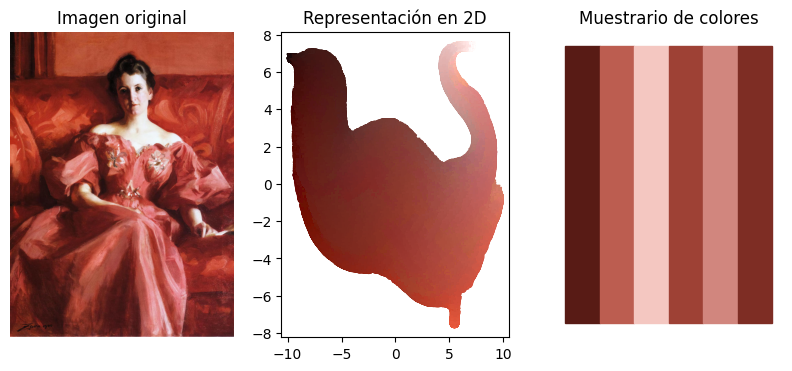

----



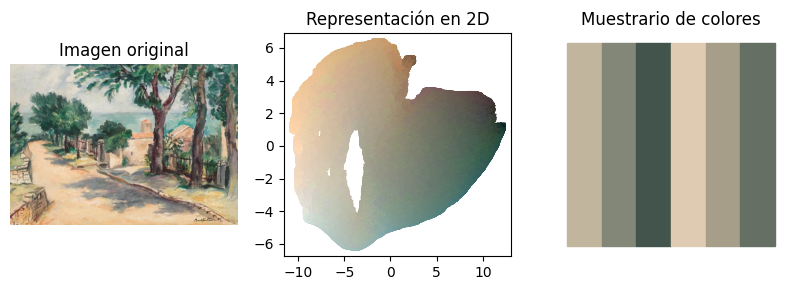

----



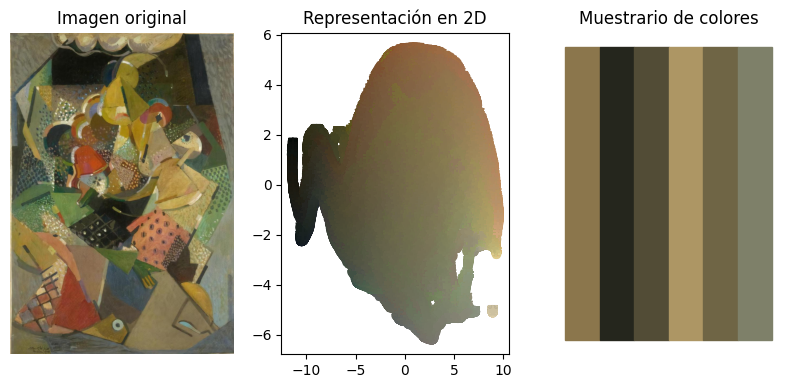

----



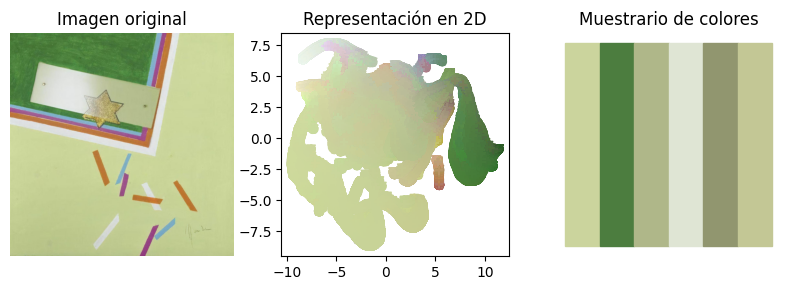

----



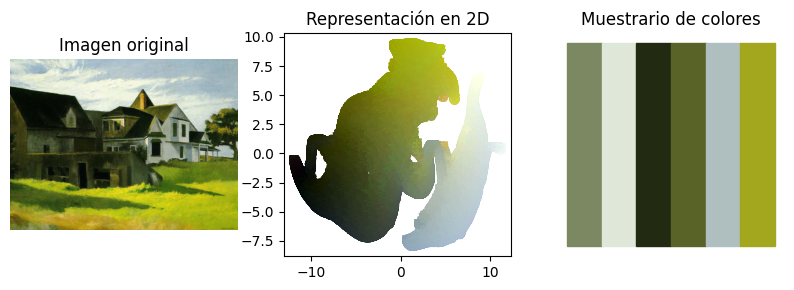

----



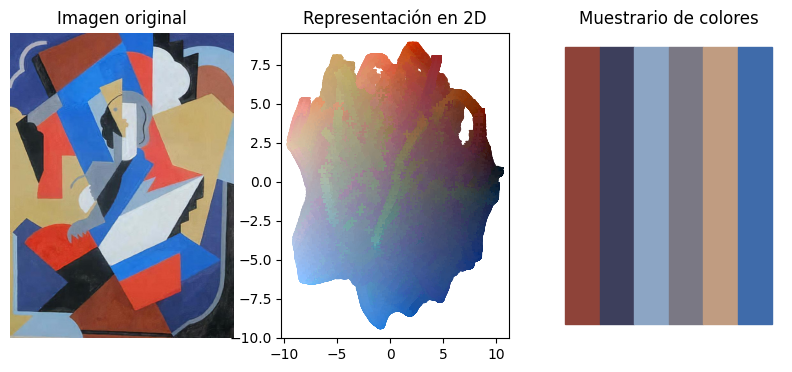

----



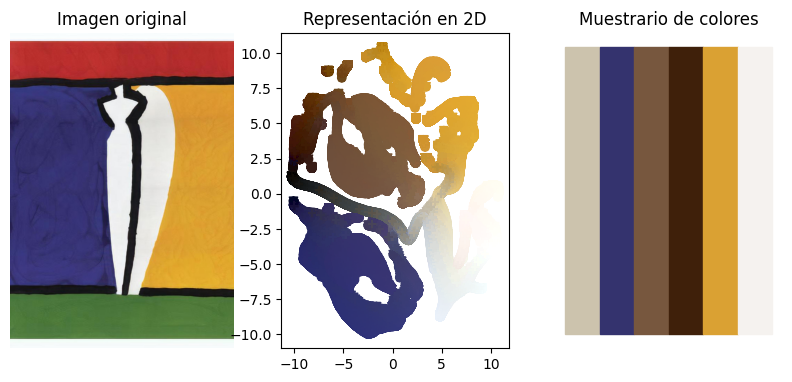

----



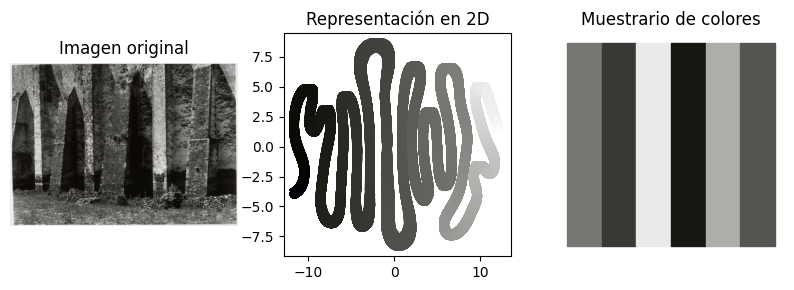

----



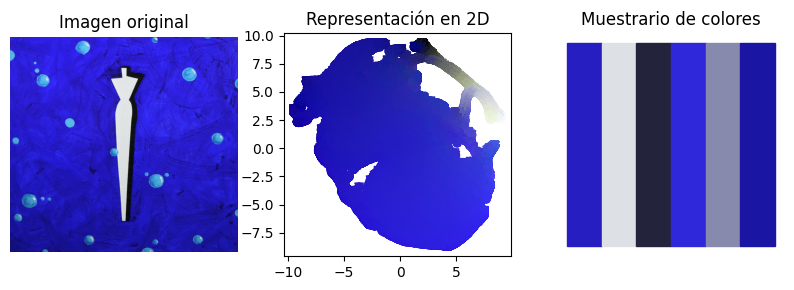

----



In [8]:
img_files = os.listdir(root_path)

for i in range(len(img_files)):  
    context = Context(model=kmeans)
    steps = [
        ("loader", ImageLoader(context)),
        ("processor", ImageProcessor(context, num_components=3)),
        ("algorithm", kmeans),
        ("prettyPrinter", PrettyPrinter(context))
    ]
    pipeline = Pipeline(steps)
    pipeline.fit(img_files[i])